# Deep Learning Brasilia
# Lesson 2 - Week challenge!

### About the dataset

The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. 
The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:

* Single-image, multi-class classification problem
* More than 40 classes
* More than 50,000 images in total
* Large, lifelike database

The details about the full GTSRB dataset and the results of the final competition that was held at IJCNN 2011 can be found in our paper "Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition" that was accepted for publication in a Neural Networks Special Issue. 

[Link to paper](http://image.diku.dk/igel/paper/MvCBMLAfTSR.pdf)

[Link to dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)

**This notebook is freely based on Udacity's Traffic Sign Classification project for the Self Driving Car Nanodegree Program, that uses the same dataset. For a reference implementation using tensorflow see: [notebook](https://github.com/lucasosouza/udacity-carnd-term1/blob/master/P2-Traffic%20Sign%20Classification/TrafficSignRecognition.ipynb)**

For the project below, the traffic signs in the original images have already been cropped, centered and resized to a standard size.

### Setting up notebook

In [1]:
# Setting AutoReload
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
# loading datasets
import sys
sys.path.insert(0, '/home/paperspace/fastai') # if using paperspace
# sys.path.insert(0, '/home/nbuser/courses/fastai') # if using crestle
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import csv
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [4]:
# check if cuda is availanle
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

### Loading files

In [5]:
### loading dataset. uncomment these lines to download and unzip dataset into same folder
# !wget https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip
# !unzip traffic-signs-data.zip
# !wget https://raw.githubusercontent.com/navoshta/traffic-signs/master/signnames.csv

In [6]:
data_path = "/home/paperspace/data/traffic-signs-data/"
# data_path = "./" 

training_file = data_path + 'train.p'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

testing_file = data_path + 'test.p'
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

labels_file = data_path + 'signnames.csv'
class_names=[]
with open(labels_file, mode='r') as f:
    reader = csv.reader(f, delimiter=',')
    next(reader)
    for row in reader:
        class_names.append(row[1])
        
X_train, y_train = train['features'], train['labels'].astype(np.int64)
X_test, y_test = test['features'], test['labels'].astype(np.int64)
# if pytorch crashes due to errors in target, change .astype(np.int32) in both lines above to .astype(np.int64)

In [7]:
# split into training and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, random_state=42)

In [8]:
# Basic data summary.

n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:3]
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_val)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("Example class =", class_names[np.random.randint(n_classes)])

Number of training examples = 27839
Number of validation examples = 6960
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43
Example class = No passing for vechiles over 3.5 metric tons


In [9]:
X_train.shape, y_train.shape

((27839, 32, 32, 3), (27839,))

In [10]:
X_train.dtype, y_train.dtype

(dtype('uint8'), dtype('int64'))

### Visualizing dataset

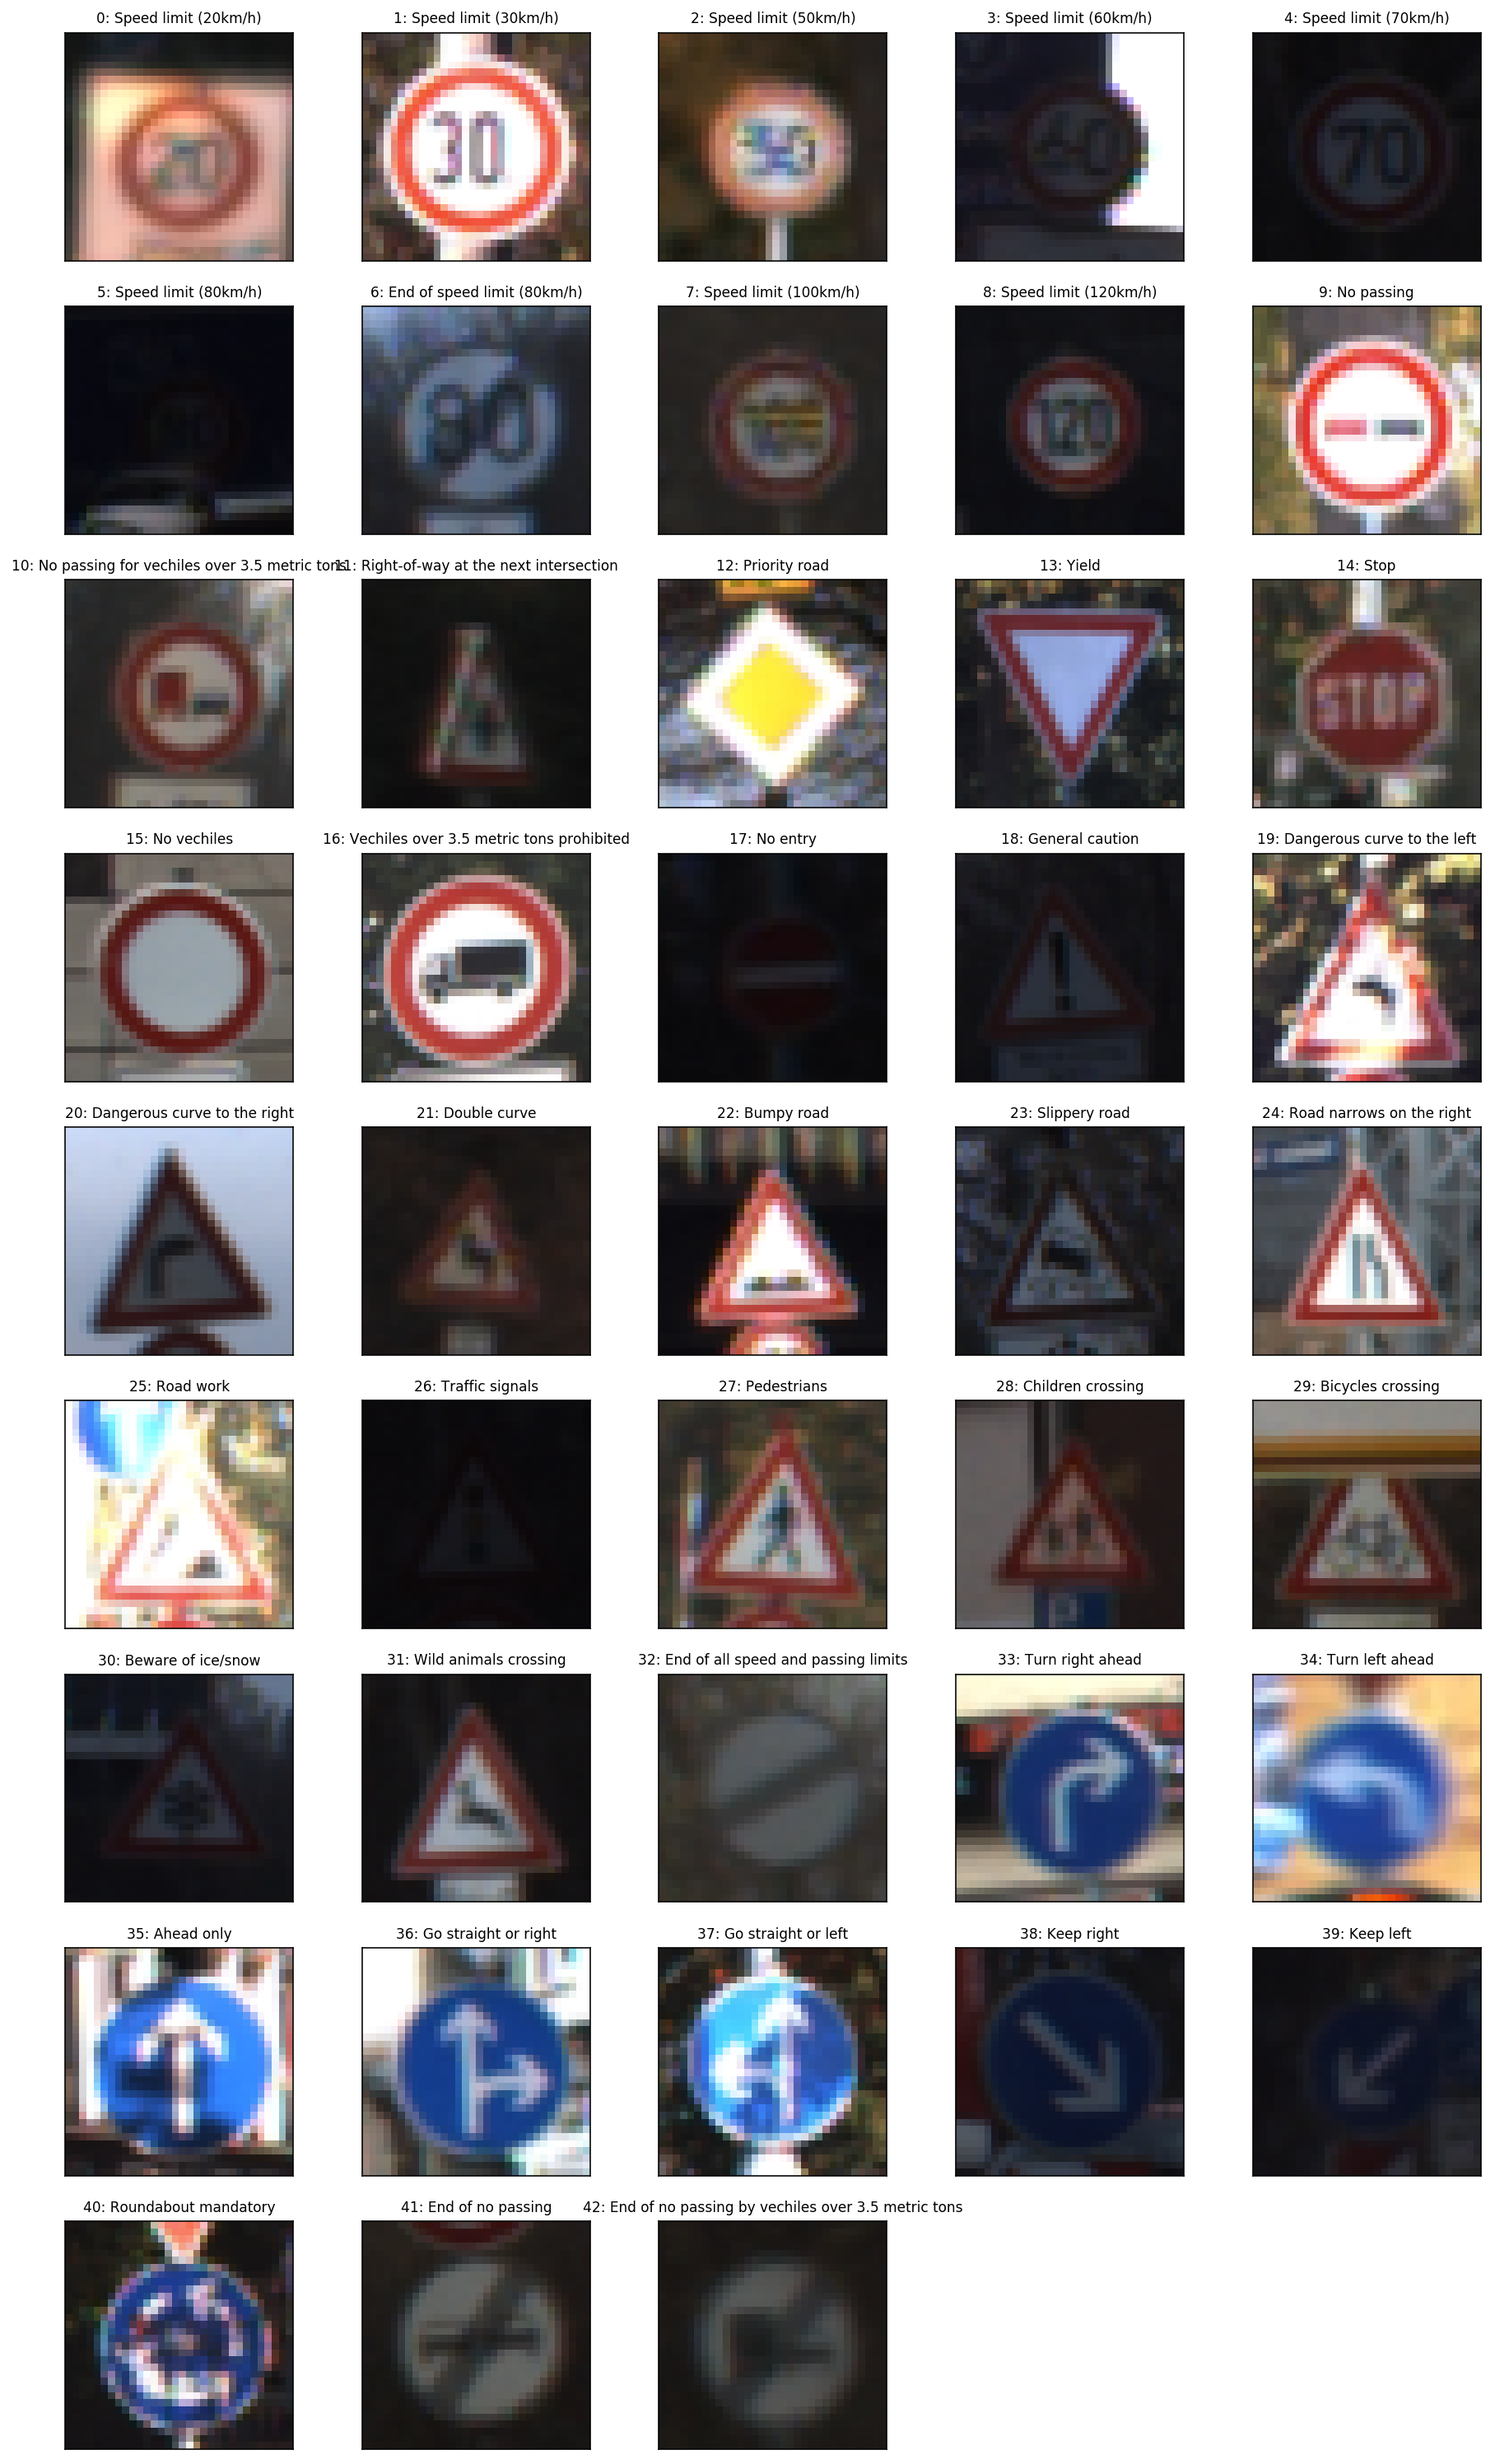

In [11]:
# show all classes
def show_all_classes(images, labels, class_names, imgs_per_row=5):

    classes = set(y_train)
    # set grid
    num_cols = int(len(classes)/imgs_per_row)+1
    plt.figure(figsize=(16, num_cols*3))
    grid = gs.GridSpec(num_cols,imgs_per_row)
    grid.update(wspace=0.05, hspace=0.2)

    # iterate and selet
    for klass in list(classes):
        indices = [idx for idx,y in enumerate(labels) if y==klass]
        img = images[np.random.choice(indices)]
        ax = plt.subplot(grid[klass])
        ax.imshow(img)
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        ax.set_title("{}: {}".format(klass, class_names[klass]), fontsize=8.5)
        
# print one image per class
show_all_classes(X_train, y_train, class_names=class_names)

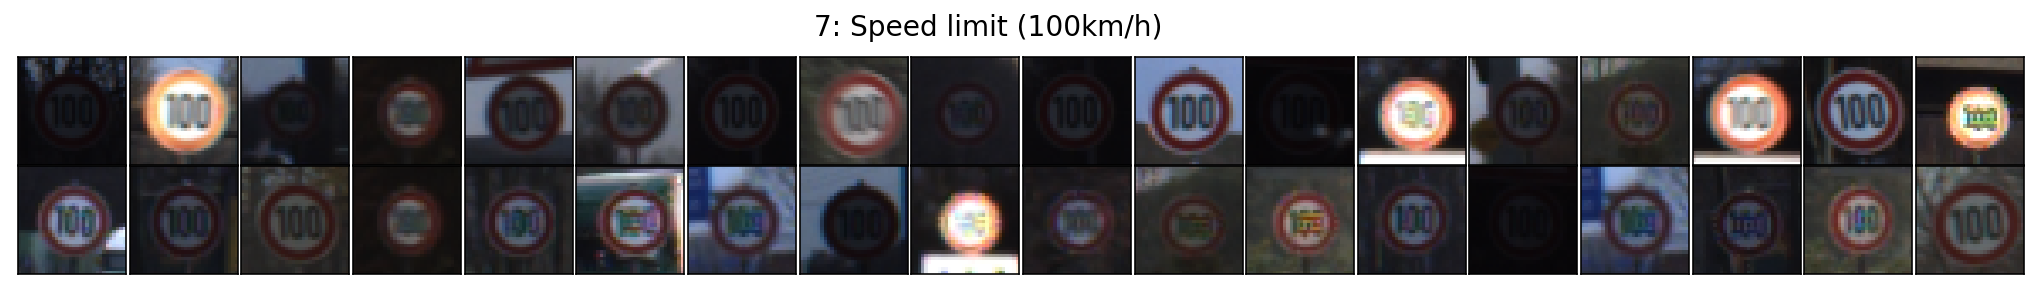

In [12]:
# show all classes
def show_samples_per_class(images, labels, class_names, selected_class, total_images=36, imgs_per_row=18):
    
    # set grid
    num_cols = int(total_images/imgs_per_row)+1
    plt.figure(figsize=(imgs_per_row, num_cols))
    grid = gs.GridSpec(num_cols,imgs_per_row)
    grid.update(wspace=0.01, hspace=0.01)

    # create title
    plt.gcf().suptitle("{}: {}".format(selected_class, class_names[selected_class]), fontsize=14)

    # select images
    indices = [idx for idx,y in enumerate(labels) if y==selected_class]
    selected_images = images[np.random.choice(indices, total_images)]
    
    # plot
    for idx in range(total_images):
        img = selected_images[idx]
        ax = plt.subplot(grid[idx])
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        ax.imshow(img)
        
# print several images of a class. Change selected_class param to see images from a different class
show_samples_per_class(X_train, y_train, class_names=class_names, selected_class=7, total_images=36)

### Build classifier

Basic model, built from lesson 1. Names and arguments are explicit to facilitate understanding

In [13]:
# define architecture
architecture = resnet34

# define data transformation strategy
transformer = tfms_from_model(architecture, sz=32, max_zoom=1.1)

# create data generator from training and validation sets
data = ImageClassifierData.from_arrays(path=data_path, 
                                       trn=(X_train, y_train), 
                                       val=(X_val, y_val),
                                       test=(X_test),
                                       bs=64,
                                       classes=class_names,
                                       tfms=transformer)

In [14]:
# create model and precompute features to speed up training
learn = ConvLearner.pretrained(architecture, data, precompute=True)

Define parameters and fit model. A few notes:
- If cycle_len is not defined, then number of epochs equals number of cycles
- If cycle_len is defined, the model will use Stochastic Gradient Descent with restarts (SGDR). In this case, number of epochs is not explicitly defined. It is given by:
$$\sum_{n=0}^{n=(n\_cycle-1)} cycle\_len*cycle\_mult^{n}$$
- Learning rate can be either a float or a list of floats. If list of floats, applies different learning rates to different layers. 



In [15]:
# define parameters
learning_rate = 0.1
n_cycle = 2
cycle_len = None
cycle_mult = 1

learn.fit(lrs=learning_rate, n_cycle=n_cycle, cycle_len=cycle_len, cycle_mult=cycle_mult,
          best_save_name='best_weights')

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.790727   2.549167   0.255925  
    1      2.621015   2.425053   0.321435                   



[2.4250526, 0.3214353976446554]

### Validate

In [16]:
# Predict in validation set
log_preds = learn.predict(is_test=False)
preds = np.argmax(log_preds, axis=1)

# Evaluate
acc = sum(preds==y_val)/preds.shape[0]
print("Accuracy in validation set: {:.4f}".format(acc))

Accuracy in validation set: 0.3223


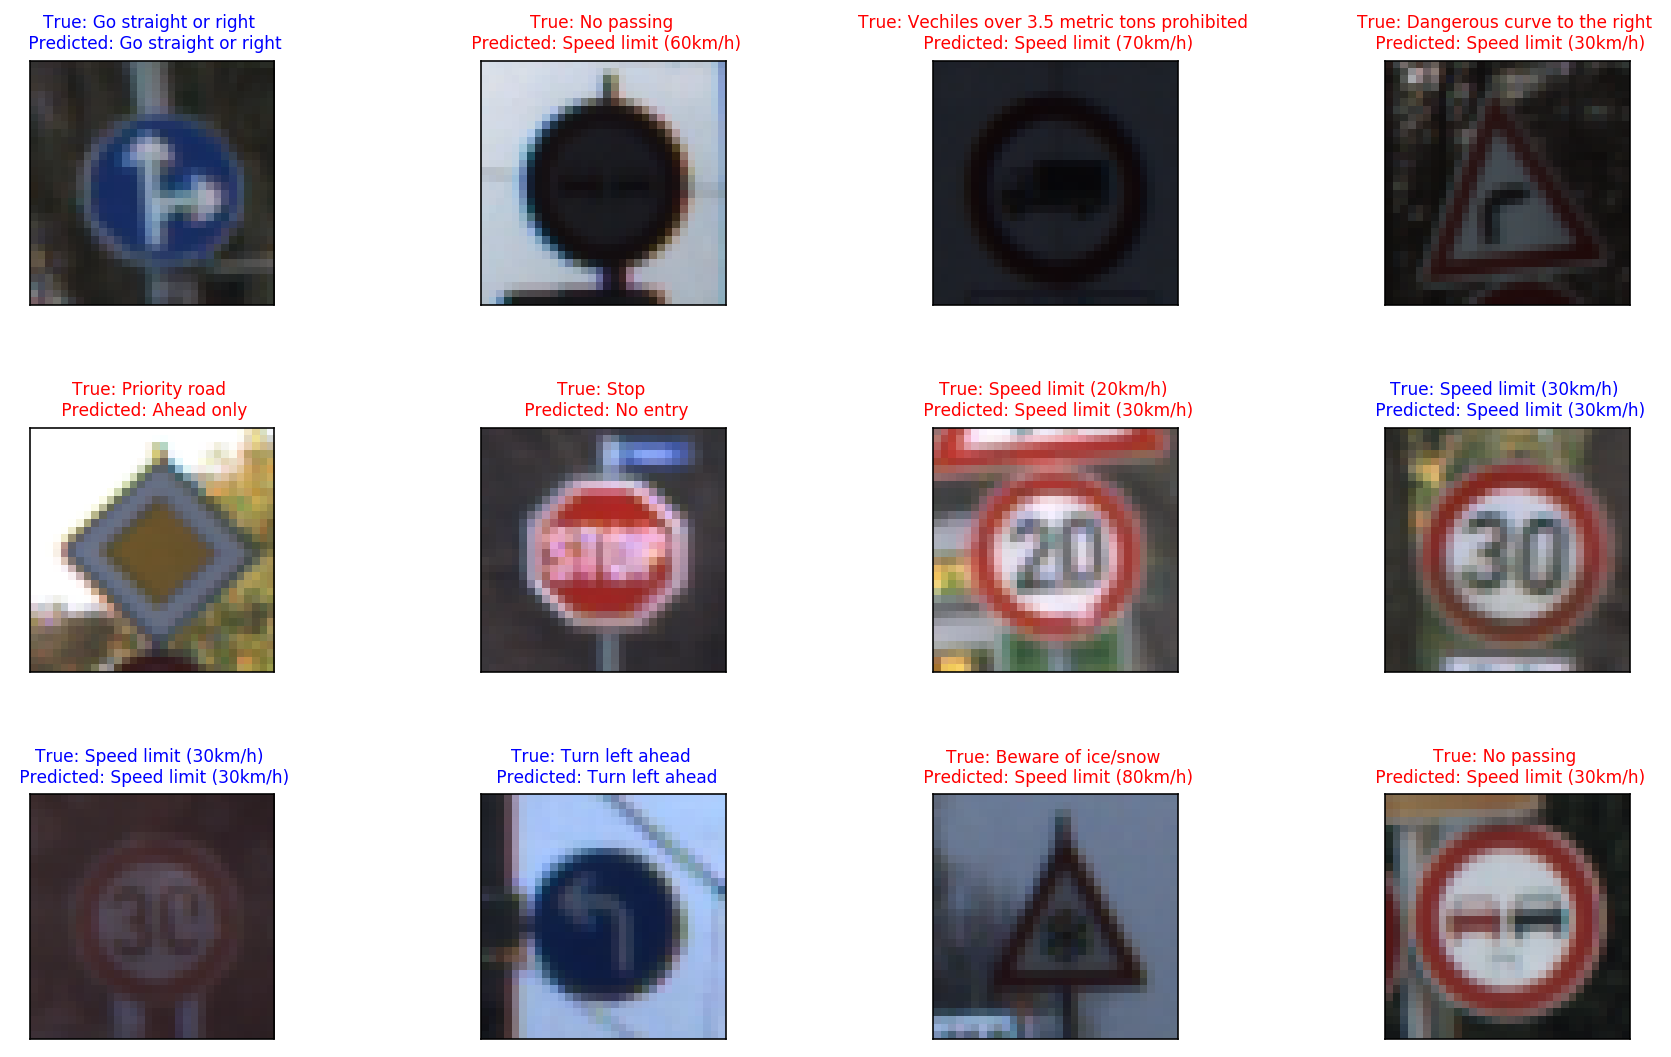

In [17]:
def show_validation_images(images, true_labels, pred_labels, imgs_per_row):
    
    num_cols = int(len(images)/imgs_per_row)
    # set grid
    plt.figure(figsize=(imgs_per_row*4, num_cols*3))
    grid = gs.GridSpec(num_cols,imgs_per_row)
    grid.update(wspace=0.05, hspace=0.5)

    # plot images
    for idx, (img, true_label, pred_label) in enumerate(zip(images, true_labels, pred_labels)):
        ax = plt.subplot(grid[idx])
        ax.imshow(img)
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        color = 'blue' if true_label == pred_label else 'red'
        ax.set_title("True: {} \n Predicted: {}".format(true_label, pred_label), fontsize=8.5, color=color)
        
# print random training images
indices = np.random.permutation(X_val.shape[0])[:12]
show_validation_images(X_val[indices], [class_names[n] for n in y_val[indices]], [class_names[n] for n in preds[indices]],
             imgs_per_row=4)

# Exercise: 
# 1. Improve model!

Your goal is to use the lessons discussed in class to improve upon this model, and try to beat the the benchmark of 97.0% accuracy in the training set.

> The model used as benchmark achieved 100% model in training, 99,8% in validation and 97% accuracy in testing set. For comparison purposes, only the accuracy in testing set (97%) is relevant. [Full notebook available here](https://github.com/lucasosouza/udacity-carnd-term1/blob/master/P2-Traffic%20Sign%20Classification/TrafficSignRecognition.ipynb)

Fastai easy steps to train a world-class image classifier:
1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

In [18]:
# options
# resnet18
# vgg16


In [19]:
sorted(list(locals().keys()), key=lambda x:x)

['A',
 'AdaptiveConcatPool2d',
 'AddPadding',
 'ArraysDataset',
 'ArraysIndexDataset',
 'ArraysNhotDataset',
 'BaseDataset',
 'BasicModel',
 'Callback',
 'CenterCrop',
 'CircularLR',
 'Compose',
 'ConvLearner',
 'ConvnetBuilder',
 'CoordTransform',
 'CosAnneal',
 'Counter',
 'CropType',
 'DataFrameSummary',
 'DataLoader',
 'Dataset',
 'Denormalize',
 'F',
 'FileLink',
 'FilesArrayDataset',
 'FilesDataset',
 'FilesIndexArrayDataset',
 'FilesIndexArrayRegressionDataset',
 'FilesNhotArrayDataset',
 'Flatten',
 'FloatTensor',
 'IPKernelApp',
 'IPython',
 'Image',
 'ImageClassifierData',
 'ImageData',
 'ImageEnhance',
 'ImageModelResults',
 'ImageOps',
 'In',
 'InceptionResnetV2',
 'InceptionV4',
 'IntEnum',
 'Iterable',
 'LR_Finder',
 'LR_Updater',
 'Lambda',
 'LayerOptimizer',
 'Learner',
 'LoggingCallback',
 'LongTensor',
 'LossRecorder',
 'ModelData',
 'NoCrop',
 'Normalize',
 'OrderedDict',
 'Out',
 'PIL',
 'PassThru',
 'Path',
 'ProcessPoolExecutor',
 'RandomBlur',
 'RandomCrop',
 'Ra

### 1. Enable data augmentation, and precompute=True

In [33]:
# define architecture
architecture = resnet18

# define data transformation strategy

# selected transformations from pytorch
# in docs: http://pytorch.org/docs/master/torchvision/transforms.html
# selected_tfms = [
#                 torchvision.transforms.Scale,
#                 torchvision.transforms.ColorJitter,
#                 torchvision.transforms.RandomRotation,
#                 ]

# no way to deactivate croppping in fastai, might be an issue
# if crop_type argument is set to None, is actually set to CropType.RANDOM
transformer = tfms_from_model(architecture, sz=32, max_zoom=1.2)

# create data generator from training and validation sets
data = ImageClassifierData.from_arrays(path=data_path, 
                                       trn=(X_train, y_train), 
                                       val=(X_val, y_val),
                                       test=(X_test),
                                       bs=64,
                                       classes=class_names,
                                       tfms=transformer)

# create model and precompute features to speed up training
learn = ConvLearner.pretrained(architecture, data, precompute=True)

### 2. Use lr_find() to find highest learning rate where loss is still clearly improving

In [27]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 82%|████████▏ | 357/435 [00:08<00:01, 40.85it/s, loss=15.7]


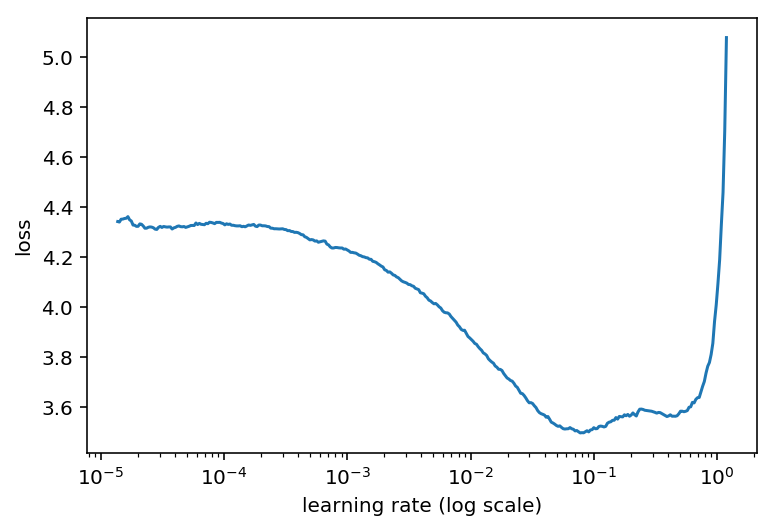

In [28]:
learn.sched.plot()

### 3. Train last layer from precomputed activations for 1-2 epochs

In [34]:
# define parameters
learning_rate = 0.05
n_cycle = 2
cycle_len = None
cycle_mult = 1

learn.fit(lrs=learning_rate, n_cycle=n_cycle, cycle_len=cycle_len, cycle_mult=cycle_mult,
          best_save_name='best_weights')

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.639765   2.655686   0.322057  
    1      2.453019   2.535854   0.373471                   



[2.5358536, 0.373470948103371]

### 4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1

In [35]:
learn.precompute=False

In [36]:
# define parameters
learning_rate = 0.05
n_cycle = 3
cycle_len = 1
cycle_mult = 1

learn.fit(lrs=learning_rate, n_cycle=n_cycle, cycle_len=cycle_len, cycle_mult=cycle_mult,
          best_save_name='best_weights')

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.365741   2.510989   0.413561  
    1      2.311116   2.50054    0.431766                   
    2      2.275445   2.443133   0.443138                   



[2.4431329, 0.44313837929603156]

### 5. Unfreeze all layers

In [37]:
learn.unfreeze()

### 6. Set earlier layers to 3x-10x lower learning rate than next higher layer


In [40]:
lr = 0.05
learning_rate = [lr/9, lr/3, lr]

### 7. Use `lr_find()` again


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 86%|████████▌ | 373/435 [00:25<00:04, 14.40it/s, loss=6.48]

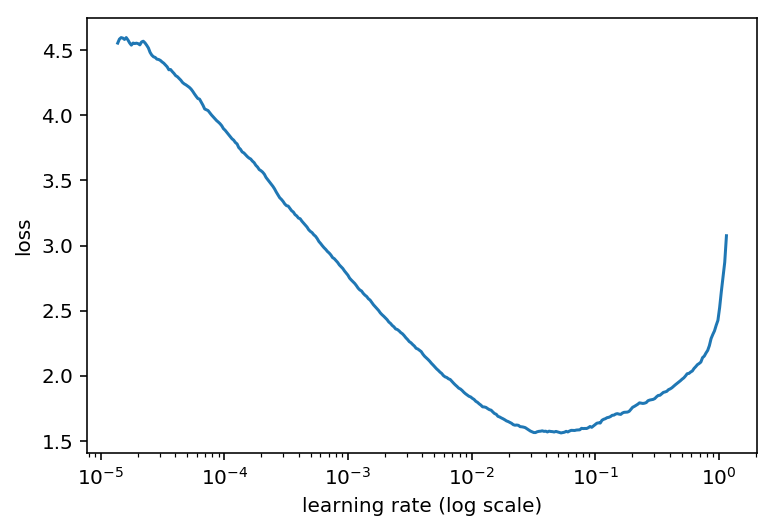

 86%|████████▌ | 373/435 [00:40<00:06,  9.32it/s, loss=6.48]

In [39]:
lrf=learn.lr_find()
learn.sched.plot()

### 8. Train full network with cycle_mult=2 until over-fitting

In [41]:
# define learning rate
lr = 5e-3
learning_rate = [lr/9, lr/3, lr]

# define parameters
n_cycle = 4
cycle_len = 1
cycle_mult = 2

learn.fit(lrs=learning_rate, n_cycle=n_cycle, cycle_len=cycle_len, cycle_mult=cycle_mult,
          best_save_name='best_weights')

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

  5%|▍         | 20/435 [00:03<01:08,  6.09it/s, loss=4.71]

Exception in thread Thread-27:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      1.102197   0.888953   0.719897  
    1      0.459597   0.272995   0.924885                    
    2      0.28957    0.195173   0.945002                    
    3      0.201932   0.094401   0.972286                    
    4      0.109553   0.058008   0.983324                    
    5      0.085195   0.043608   0.987481                     
    6      0.063562   0.03959    0.989344                     
    7      0.080944   0.054709   0.982177                     
    8      0.062756   0.034179   0.989106                     
    9      0.058291   0.029959   0.991399                     
    10     0.038946   0.023439   0.993549                     
    11     0.027713   0.020822   0.994553                     
    12     0.023178   0.017902   0.994266                     
    13     0.020825   0.017453   0.994553                     
    14     0.020806   0.0172     0.994839                     



[0.017199581, 0.9948394495412844]

In [55]:
# still not overfitting - train longer
# define learning rate
lr = 5e-3
learning_rate = [lr/9, lr/3, lr]

# define parameters
n_cycle = 6
cycle_len = 1
cycle_mult = 2

learn.fit(lrs=learning_rate, n_cycle=n_cycle, cycle_len=cycle_len, cycle_mult=cycle_mult,
          best_save_name='best_weights')

HBox(children=(IntProgress(value=0, description='Epoch', max=63), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.025168   0.014676   0.995413  
    1      0.031534   0.021972   0.991829                     
    2      0.02024    0.019223   0.994266                     
    3      0.026792   0.016448   0.994983                     
    4      0.020688   0.013948   0.99613                      
    5      0.017698   0.012297   0.996703                     
    6      0.013938   0.01254    0.99656                      
    7      0.023943   0.01848    0.994553                     
    8      0.020025   0.013676   0.995986                     
    9      0.015641   0.011198   0.996655                     
    10     0.013062   0.014047   0.995843                     
    11     0.012222   0.00994    0.996846                      
    12     0.009016   0.009689   0.997276                      
    13     0.008507   0.0095     0.99742                       
    14     0.007727   0.009285   0.997133                      
    15 

[0.0064052315, 0.997993119266055]

In [61]:
np.vstack([X_train, X_val]).shape

(34799, 32, 32, 3)

In [59]:
X_train.shape, X_val.shape

((27839, 32, 32, 3), (6960, 32, 32, 3))

### 9. Stack training and validation set. Retrain

In [72]:
# define architecture
architecture = resnet18

# define data transformation strategy
transformer = tfms_from_model(architecture, sz=32, max_zoom=1.2)

# create data generator from training and validation sets
# reduce batch_size
data = ImageClassifierData.from_arrays(path=data_path, 
                                       trn=(np.vstack([X_train, X_val]), np.hstack([y_train, y_val])), 
                                       val=(X_val, y_val),
                                       test=(X_test),
                                       bs=16,
                                       classes=class_names,
                                       tfms=transformer)


In [75]:
learn.set_data(data)

In [76]:
# set lower learning_rate, finetuning previously trained model
lr = 5e-4
learning_rate = [lr/9, lr/3, lr]

# define parameters
n_cycle = 3
cycle_len = 1
cycle_mult = 2

learn.fit(lrs=learning_rate, n_cycle=n_cycle, cycle_len=cycle_len, cycle_mult=cycle_mult,
          best_save_name='best_weights')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                        
    0      0.001402   0.006604   0.998276  
    1      0.002149   0.00642    0.997845                         
    2      0.007026   0.006309   0.997989                        
    3      0.002797   0.006064   0.998276                         
    4      0.005235   0.006279   0.998276                         
    5      0.001363   0.006234   0.997989                        
    6      0.009643   0.00625    0.998276                         



[0.0062498283, 0.9982758620689656]

In [77]:
# train for 6 more epochs, without restarts
# trying to reduce training loss to <0.0002

lr = 5e-4
learning_rate = [lr/9, lr/3, lr]

# define parameters
n_cycle = 6
cycle_len = None
cycle_mult = 1

learn.fit(lrs=learning_rate, n_cycle=n_cycle, cycle_len=cycle_len, cycle_mult=cycle_mult,
          best_save_name='best_weights')

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                         
    0      0.004242   0.00659    0.997845  
    1      0.001398   0.006055   0.998132                         
    2      0.002038   0.005956   0.99842                          
    3      0.002144   0.006152   0.998276                         
    4      0.009483   0.005932   0.998132                         
    5      0.000916   0.005606   0.99842                          



[0.005606233, 0.9984195402298851]

# 2. Test and report

**Important:** to avoid [data leakage](https://www.kaggle.com/wiki/Leakage), only run your final model on the test set. Use the validation set to iterate through different model versions. 

In [78]:
# Predict in test set
log_preds = learn.predict(is_test=True)
probs = np.exp(log_preds)
preds = np.argmax(probs, axis=1)

# Evaluate
acc = sum(preds==y_test)/preds.shape[0]
print("Accuracy in test set: {:.4f}".format(acc))

Accuracy in test set: 0.9139


In [79]:
# Predict in test set
log_preds = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds[0]), 0)
preds = np.argmax(probs, axis=1)

# Evaluate
acc = sum(preds==y_test)/preds.shape[0]
print("Accuracy in test set: {:.4f}".format(acc))

Accuracy in test set: 0.9280                 


In [80]:
# load best weights
learn.load('best_weights')

In [81]:
# Predict in test set
log_preds = learn.predict(is_test=True)
probs = np.exp(log_preds)
preds = np.argmax(probs, axis=1)

# Evaluate
acc = sum(preds==y_test)/preds.shape[0]
print("Accuracy in test set: {:.4f}".format(acc))

Accuracy in test set: 0.9139


In [82]:
# Predict in test set
log_preds = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds[0]), 0)
preds = np.argmax(probs, axis=1)

# Evaluate
acc = sum(preds==y_test)/preds.shape[0]
print("Accuracy in test set: {:.4f}".format(acc))

Accuracy in test set: 0.9280                 
